Importing the basic libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Taking our data X(our inputs), Y(the labels) 
for implementing I made synthetic data 

In [2]:
X = np.array([
    [1, 1],
    [1, 8],
    [2, 4],
    [2, 6],
    [3, 5],
    [3, 7],
    [4, 6],
    [4, 8],
    [5, 3],
    [5, 5],
    [6, 4],
    [6, 6],
    [7, 3],
    [7, 5],
    [8, 4]
])


In [3]:
y = np.array([
    0, 0, 0, 0, 0,   
    0, 1, 0,        
    1, 0, 1, 1,
    1, 1, 1
])


In [4]:
n = np.size(y)
n

15

Visualizing our data 

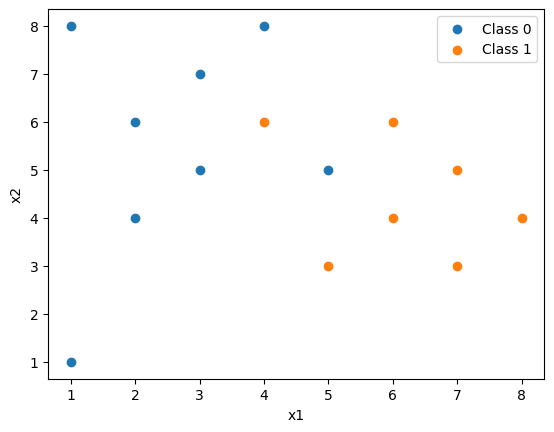

In [5]:
plt.scatter(X[y==0, 0], X[y==0, 1], label="Class 0")
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class 1")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In our model we are working with three different losses Entropy Loss,Missclassification Loss and Gini loss 
we will use these to find best splits 

In [6]:
def Entropy_loss(y):
    n = len(y)
    if (len(y) ==0):
        return 0
    counts = np.bincount(y)
    p = counts / n

    L = 0
    for pi in p:
        if(pi>0):
            L = L - pi*np.log2(pi)  

    return L
    

In [7]:
L_cross = Entropy_loss(y)
L_cross

np.float64(0.9967916319816366)

In [8]:
def Missclass_loss(y):
    n = len(y)
    if (len(y) ==0):
        return 0
    counts = np.bincount(y)
    p = counts / n

    L = 1 - np.max(p)
    return L

In [9]:
L_miss = Missclass_loss(y)
L_miss

np.float64(0.4666666666666667)

In [10]:
def Gini_loss(y):
    n = len(y)
    if (len(y) ==0):
        return 0
    counts = np.bincount(y)
    p = counts / n

    L = 0
    for pi in p:
          L = L + pi * (1 - pi)
    return L    
    

In [11]:
L_gini = Gini_loss(y)
L_gini

np.float64(0.49777777777777776)

Creating the function for splitting our dataset according to a question and also calculating the loss after that slit by split_loss function
here this only works for numerical data and not categorical data 

In [12]:
def split_dataset(X, y, feature_index, threshold):
    mask = X[:, feature_index] <= threshold

    X_left = X[mask]
    y_left = y[mask]

    X_right = X[~mask]
    y_right = y[~mask]

    return X_left, y_left, X_right, y_right


In [13]:
Xl, yl, Xr, yr = split_dataset(X, y, feature_index=0, threshold=4.5)

print(len(yl), len(yr))
print(yl)
print(yr)


8 7
[0 0 0 0 0 0 1 0]
[1 0 1 1 1 1 1]


In [14]:
def split_loss(X, y, feature_index, threshold, impurity_fn):
    X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)

    n = len(y)
    loss = (len(y_left)/n) * impurity_fn(y_left) + \
           (len(y_right)/n) * impurity_fn(y_right)

    return loss


In [15]:
loss_1 = split_loss(X, y, 0, 4.5, Entropy_loss)
loss_2 = split_loss(X, y, 0, 3.5, Entropy_loss)
loss_3 = split_loss(X, y, 0, 5.5, Entropy_loss)

print(loss_1, loss_2, loss_3)


0.5660149997115376 0.45852270390517214 0.4812853965915749


Finding the best split based on some type of loss (which splits reduces our loss the most)

In [16]:
def find_best_split(X,y,impurity_fn):
    n_samples, n_features = X.shape
    best_loss = float("inf")
    best_feature,best_threshold = None,None

    for j in range(n_features):
        values = np.unique(X[:,j])
        values.sort()
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            loss = split_loss(X, y, j, t, impurity_fn)

            if loss < best_loss:
                best_loss = loss
                best_feature = j
                best_threshold = t
    return best_feature, best_threshold, best_loss         
        

In [17]:
best_feature,best_threshold,best_loss = find_best_split(X,y, Entropy_loss)
print(best_feature)
print(best_threshold)
print(best_loss)

0
3.5
0.45852270390517214


In [18]:
def Majority_class(y):
    counts = np.bincount(y)
    value = np.argmax(counts)
    return value


Creating a basic tree of just 2 levels (one parent and its child ) basic implementation to check 

In [19]:
class Decision_stump:
    def __init__(self,impurity_fn):
        self.impurity_fn = impurity_fn
        self.best_feature = None
        self.best_threshold = None
        self.left_val = None
        self.right_val = None
        
    def fit(self, X, y):
        self.best_feature,self.best_threshold,best_loss = find_best_split(X,y,self.impurity_fn)
        Xl, yl, Xr, yr = split_dataset(X, y, self.best_feature, self.best_threshold)
        self.left_val = Majority_class(yl)
        self.right_val = Majority_class(yr)
        return self

    def predict(self, X):
        preds = []

        for x in X:
            if x[self.best_feature] <= self.best_threshold:
                preds.append(self.left_val)
            else:
                preds.append(self.right_val)

        return np.array(preds)
        

In [20]:
stump = Decision_stump(Entropy_loss)
stump.fit(X, y)
preds = stump.predict(X)
print(preds)


[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


Creating our class Node 

In [21]:
class Node:
    def __init__(self, best_feature = None,best_threshold = None, left = None, right = None, value = None):
        self.best_feature = best_feature
        self.best_threshold = best_threshold
        self.left = left
        self.right = right
        self.value = value      
    

Creating the decision tree class

In [22]:
class DecisionTree:
    def __init__(self, impurity_fn, max_depth, min_samples_leaf = 1):
        self.impurity_fn = impurity_fn
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    
    def build_tree(self, X, y, depth):
        if (depth >= self.max_depth or len(y) < self.min_samples_leaf or len(np.unique(y)) == 1):
            return Node(value = Majority_class(y))
    
        feature,threshold,loss = find_best_split(X, y, self.impurity_fn)
    
        Xl, yl, Xr, yr = split_dataset(X, y, feature, threshold)
    
        left_child  = self.build_tree(Xl, yl, depth + 1)
        right_child = self.build_tree(Xr, yr, depth + 1)
    
        return Node(
            best_feature = feature,
            best_threshold = threshold,
            left = left_child,
            right = right_child
        )

    def fit(self, X, y):
        self.root = self.build_tree(X, y, depth=0)
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            node = self.root        
            while node.value is None:
                if x[node.best_feature] <= node.best_threshold:
                    node = node.left
                else:
                    node = node.right        
            predictions.append(node.value)
    
        return np.array(predictions)                    

Implementing on our data and checking accuracy 

In [23]:
tree = DecisionTree(Entropy_loss, max_depth=3)
tree.fit(X, y)
preds = tree.predict(X)
print("Predictions:", preds)
print("Accuracy:", np.mean(preds == y))


Predictions: [0 0 0 0 0 0 0 0 1 0 1 1 1 1 1]
Accuracy: 0.9333333333333333


Testing on a little larger (Synthetic) data

In [24]:
X1 = np.array([
    [2.1, 3.5, 1.2],
    [1.8, 2.9, 0.8],
    [2.5, 3.0, 1.0],
    [3.0, 2.7, 1.5],
    [2.2, 2.5, 0.9],
    [3.1, 3.2, 1.7],
    [1.5, 3.6, 1.1],
    [2.8, 2.2, 0.7],
    [3.3, 3.1, 1.4],
    [2.0, 2.8, 1.3],

    [4.1, 3.8, 2.0],
    [3.9, 4.0, 2.2],
    [4.5, 3.5, 1.8],
    [3.6, 4.2, 2.1],
    [4.8, 3.9, 2.4],
    [4.2, 4.4, 2.6],
    [3.7, 3.6, 2.0],
    [4.0, 4.1, 2.3],
    [4.6, 3.7, 1.9],
    [3.8, 4.3, 2.5],

    [2.9, 4.0, 2.8],
    [3.2, 4.5, 3.0],
    [3.5, 4.2, 2.7],
    [2.7, 4.6, 3.2],
    [3.0, 4.8, 3.4],
    [3.6, 4.7, 3.1],
    [2.8, 4.3, 2.9],
    [3.4, 4.9, 3.5],
    [3.1, 4.1, 2.6],
    [3.7, 4.4, 3.3],

    [1.9, 3.8, 2.2],
    [2.4, 3.3, 1.9],
    [3.9, 3.0, 2.1],
    [4.3, 2.9, 1.8],
    [2.6, 3.9, 2.4],
    [3.8, 3.4, 2.0],
    [4.1, 3.2, 2.3],
    [2.3, 3.7, 2.1],
    [3.5, 3.5, 2.2],
    [4.0, 3.3, 1.9],
])

y1 = np.array([
    0,0,0,1,0,1,0,0,0,0,
    1,1,1,1,1,1,0,1,1,1,
    1,1,1,0,1,0,1,1,1,1,
    0,0,1,1,0,1,1,0,1,1
])


In [31]:
tree = DecisionTree(Entropy_loss, max_depth=3)
tree.fit(X1, y1)

preds = tree.predict(X1)
print("Predictions:", preds)
print("Accuracy:", np.mean(preds == y1))


Predictions: [0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1
 0 1 1]
Accuracy: 0.95


In [32]:
tree = DecisionTree(Entropy_loss, max_depth=5)
tree.fit(X1, y1)

preds = tree.predict(X1)
print("Predictions:", preds)
print("Accuracy:", np.mean(preds == y1))

Predictions: [0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1
 0 1 1]
Accuracy: 0.975


In [36]:
tree = DecisionTree(Gini_loss, max_depth=5)
tree.fit(X1, y1)

preds = tree.predict(X1)
print("Predictions:", preds)
print("Accuracy:", np.mean(preds == y1))

Predictions: [0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1
 0 1 1]
Accuracy: 0.975


Comparing from sklearn's decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [40]:
sk_tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    random_state=42
)
sk_tree.fit(X1, y1)
sk_preds = sk_tree.predict(X1)
print("Sklearn Tree Accuracy:", accuracy_score(y1, sk_preds))

Sklearn Tree Accuracy: 0.975


Trying this on a non synthetic dataset(Breast Cancer dataset from sklearn)

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [42]:
my_tree = DecisionTree(Entropy_loss, max_depth=5)
my_tree.fit(X_train, y_train)
my_preds = my_tree.predict(X_test)


sk_tree = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    random_state=42
)
sk_tree.fit(X_train, y_train)
sk_preds = sk_tree.predict(X_test)

print("My Tree Accuracy:", accuracy_score(y_test, my_preds))
print("Sklearn Tree Accuracy:", accuracy_score(y_test, sk_preds))


My Tree Accuracy: 0.9385964912280702
Sklearn Tree Accuracy: 0.9473684210526315
